In [1]:
from pathlib import Path
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
price = pd.read_csv("germany_price.csv")
price.columns = ["data", "price"]
price.data = pd.to_datetime(price.data)
price.index = price.data
price.head()

,data,price
data,,
2020-01-01 00:00:00+01:00,2020-01-01 00:00:00+01:00,41.88
2020-01-01 01:00:00+01:00,2020-01-01 01:00:00+01:00,38.60
2020-01-01 02:00:00+01:00,2020-01-01 02:00:00+01:00,36.55
2020-01-01 03:00:00+01:00,2020-01-01 03:00:00+01:00,32.32
2020-01-01 04:00:00+01:00,2020-01-01 04:00:00+01:00,30.85


In [3]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [4]:
df = price.copy()
# df = df[-10200:-1]
df["Time"] = np.arange(len(df.index))
df.head()

,data,price,Time
data,,,
2020-01-01 00:00:00+01:00,2020-01-01 00:00:00+01:00,41.88,0
2020-01-01 01:00:00+01:00,2020-01-01 01:00:00+01:00,38.60,1
2020-01-01 02:00:00+01:00,2020-01-01 02:00:00+01:00,36.55,2
2020-01-01 03:00:00+01:00,2020-01-01 03:00:00+01:00,32.32,3
2020-01-01 04:00:00+01:00,2020-01-01 04:00:00+01:00,30.85,4


### Time-step feature

In [5]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'price']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

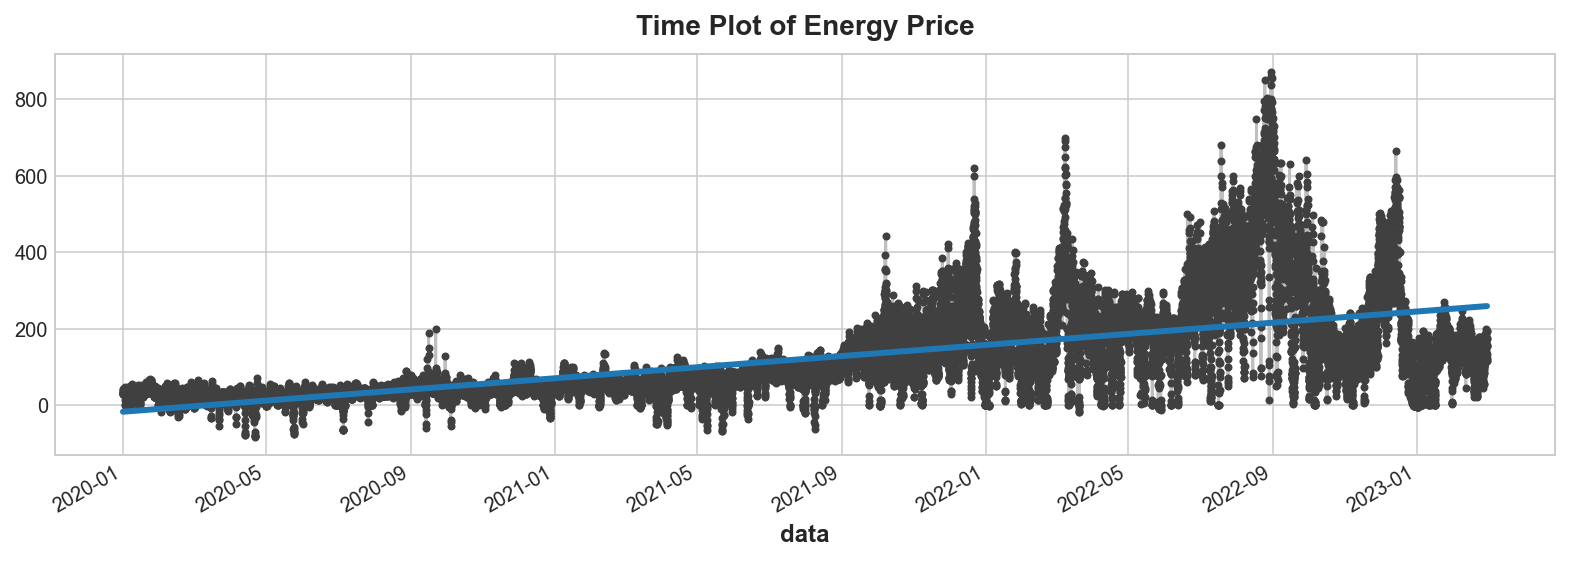

In [6]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Energy Price');

### Lag feature

In [7]:
df['Lag_1'] = df['price'].shift(1)
df.head()

,data,price,Time,Lag_1
data,,,,
2020-01-01 00:00:00+01:00,2020-01-01 00:00:00+01:00,41.88,0,NaN
2020-01-01 01:00:00+01:00,2020-01-01 01:00:00+01:00,38.60,1,41.88
2020-01-01 02:00:00+01:00,2020-01-01 02:00:00+01:00,36.55,2,38.60
2020-01-01 03:00:00+01:00,2020-01-01 03:00:00+01:00,32.32,3,36.55
2020-01-01 04:00:00+01:00,2020-01-01 04:00:00+01:00,30.85,4,32.32


In [8]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'price']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

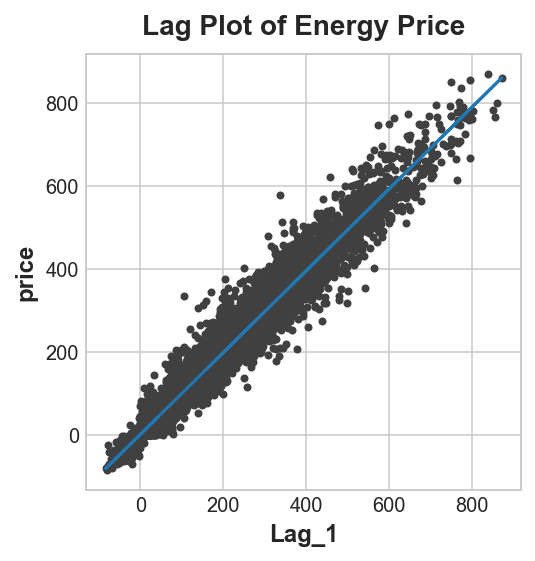

In [9]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('price')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Energy Price');

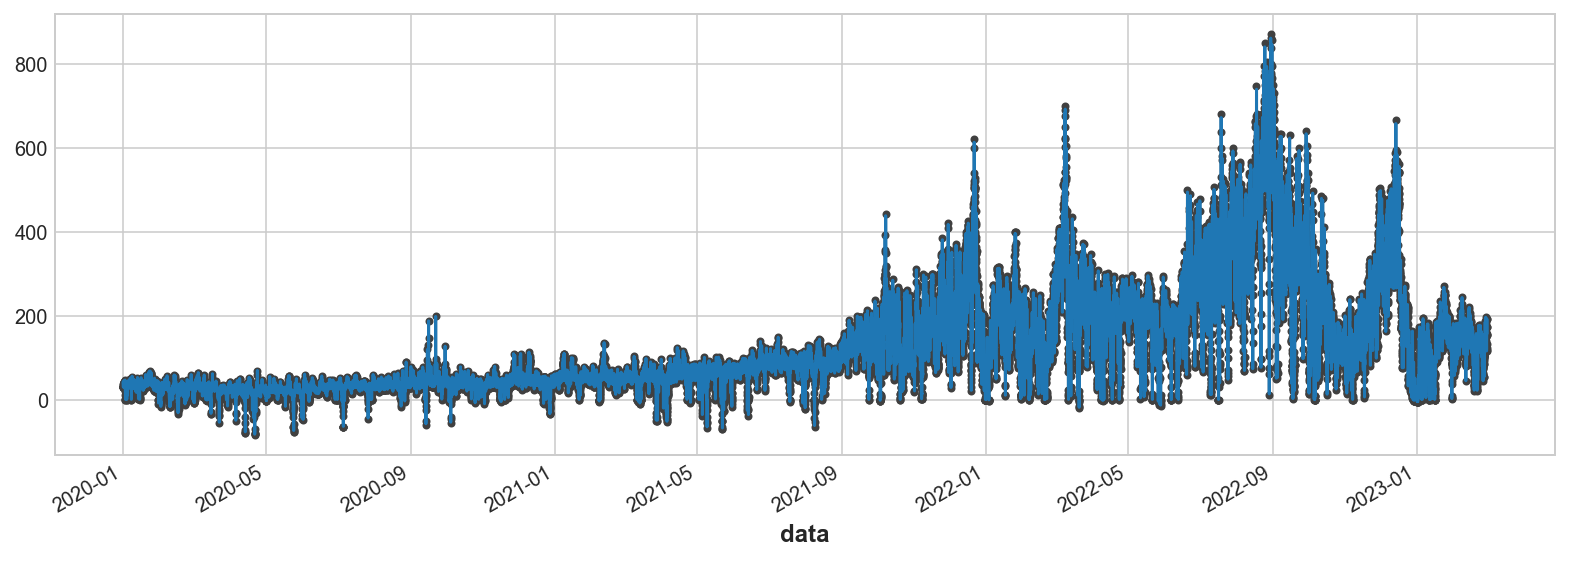

In [10]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

# Trend

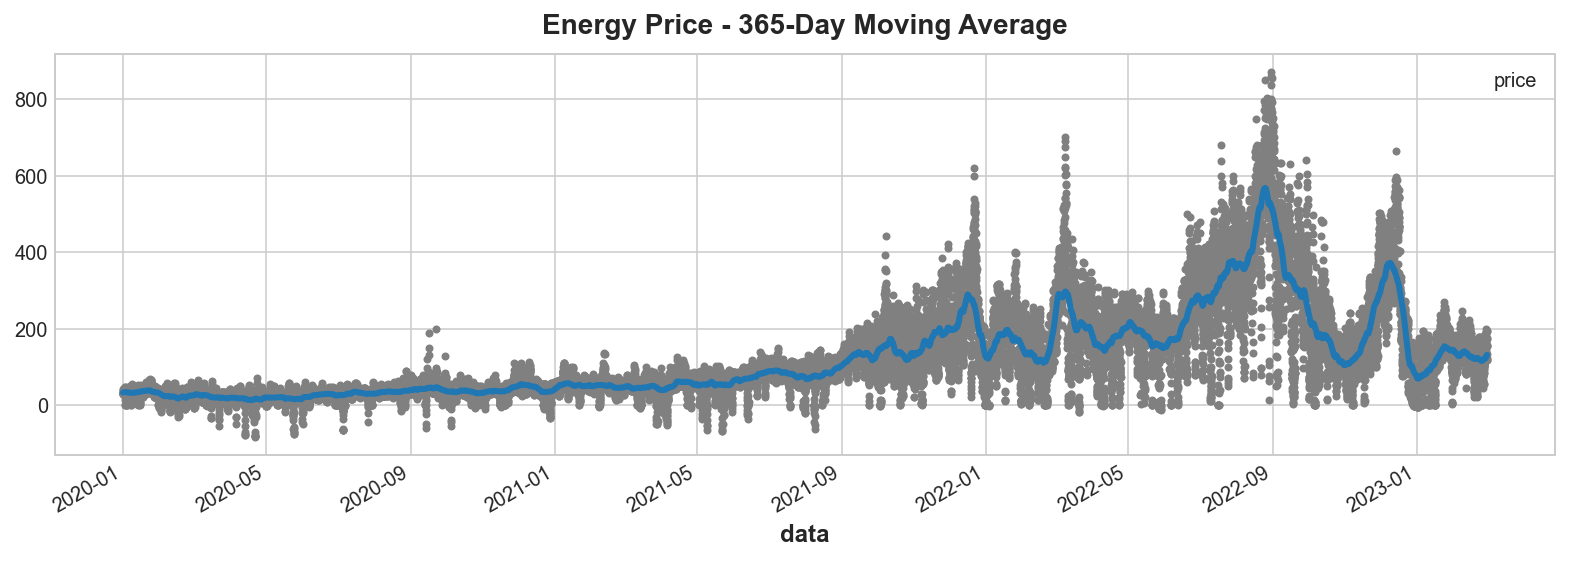

In [11]:
moving_average = price.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = price.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Energy Price - 365-Day Moving Average", legend=False,
);

In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=price.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
data,,
2020-01-01 00:00:00+01:00,1.0,1.0
2020-01-01 01:00:00+01:00,1.0,2.0
2020-01-01 02:00:00+01:00,1.0,3.0
2020-01-01 03:00:00+01:00,1.0,4.0
2020-01-01 04:00:00+01:00,1.0,5.0


In [13]:
from sklearn.linear_model import LinearRegression

y = price["price"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

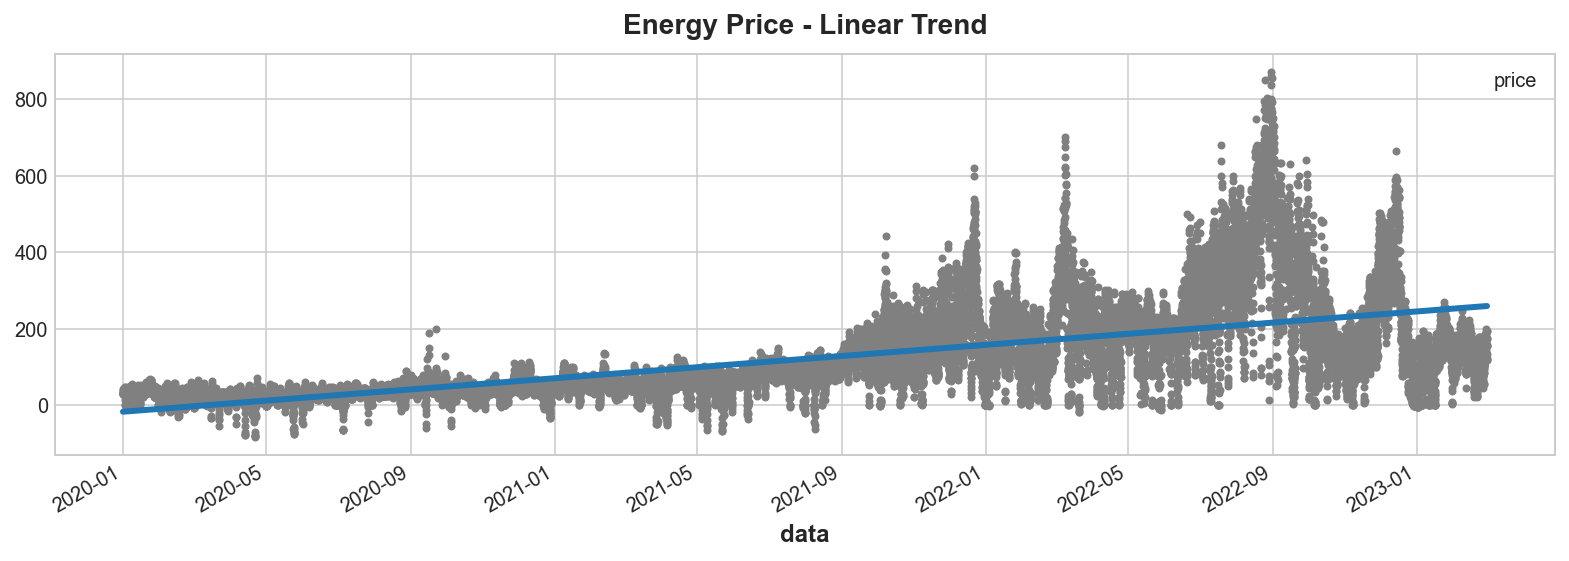

In [14]:
ax = price.plot(style=".", color="0.5", title="Energy Price - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [15]:
X = dp.out_of_sample(steps=24)
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore

27720    259.141519
27721    259.151491
27722    259.161462
27723    259.171433
27724    259.181404
27725    259.191376
27726    259.201347
27727    259.211318
27728    259.221290
27729    259.231261
27730    259.241232
27731    259.251204
27732    259.261175
27733    259.271146
27734    259.281117
27735    259.291089
27736    259.301060
27737    259.311031
27738    259.321003
27739    259.330974
27740    259.340945
27741    259.350917
27742    259.360888
27743    259.370859
dtype: float64

In [16]:
test_date = price.iloc[-1].data
date_generated = pd.date_range(test_date, periods=24, freq='H')
y_fore.index = date_generated
y_fore

2023-02-28 22:00:00+01:00    259.141519
2023-02-28 23:00:00+01:00    259.151491
2023-03-01 00:00:00+01:00    259.161462
2023-03-01 01:00:00+01:00    259.171433
2023-03-01 02:00:00+01:00    259.181404
2023-03-01 03:00:00+01:00    259.191376
2023-03-01 04:00:00+01:00    259.201347
2023-03-01 05:00:00+01:00    259.211318
2023-03-01 06:00:00+01:00    259.221290
2023-03-01 07:00:00+01:00    259.231261
2023-03-01 08:00:00+01:00    259.241232
2023-03-01 09:00:00+01:00    259.251204
2023-03-01 10:00:00+01:00    259.261175
2023-03-01 11:00:00+01:00    259.271146
2023-03-01 12:00:00+01:00    259.281117
2023-03-01 13:00:00+01:00    259.291089
2023-03-01 14:00:00+01:00    259.301060
2023-03-01 15:00:00+01:00    259.311031
2023-03-01 16:00:00+01:00    259.321003
2023-03-01 17:00:00+01:00    259.330974
2023-03-01 18:00:00+01:00    259.340945
2023-03-01 19:00:00+01:00    259.350917
2023-03-01 20:00:00+01:00    259.360888
2023-03-01 21:00:00+01:00    259.370859
Freq: H, dtype: float64

In [17]:
import pytz
start_datetime = datetime.strptime('2023-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
start_datetime = start_datetime.replace(tzinfo=pytz.utc)

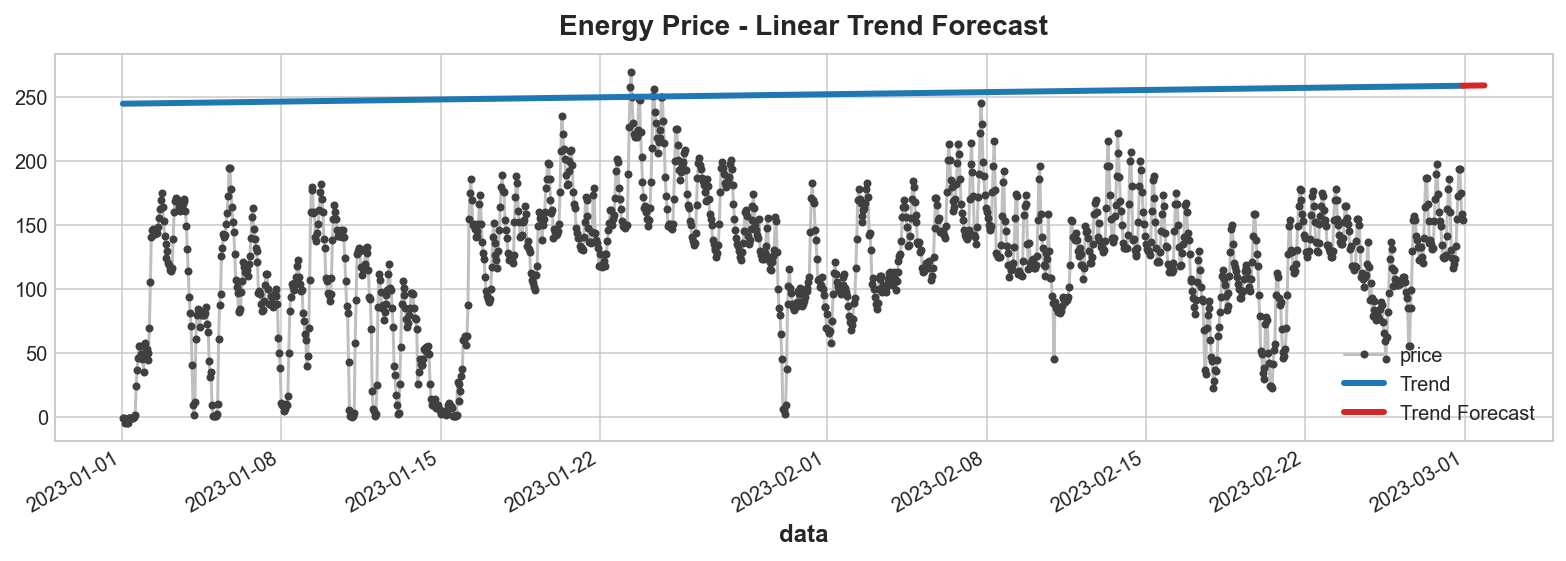

In [18]:
test = price.drop("data", axis=1)
ax = test[start_datetime:].plot(title="Energy Price - Linear Trend Forecast", **plot_params)
ax = y_pred[start_datetime:].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

### Seasonality

In [19]:
import seaborn as sns
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='price'>

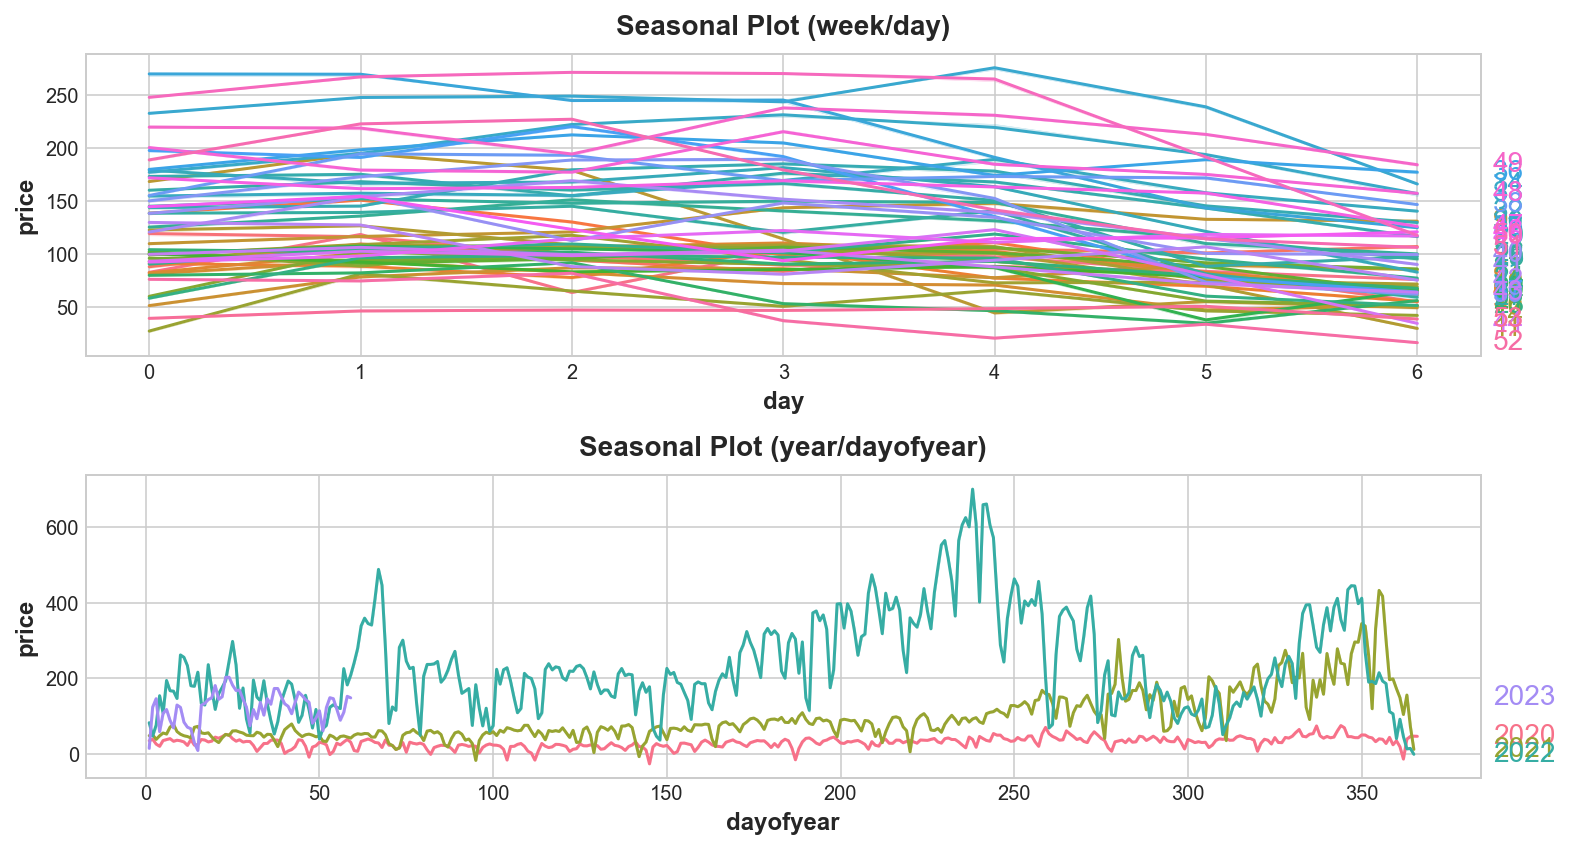

In [20]:
X = price.copy()
X["day"] = X["data"].apply (lambda row: row.weekday())
X["week"] = X["data"].apply (lambda row: row.isocalendar()[1])
X["dayofyear"] = X["data"].apply (lambda row: row.timetuple().tm_yday)
X["year"] = X["data"].apply (lambda row: row.year)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11,6))
seasonal_plot(X, y='price', period='week', freq='day', ax=ax0)
seasonal_plot(X, y='price', period="year", freq="dayofyear", ax=ax1)

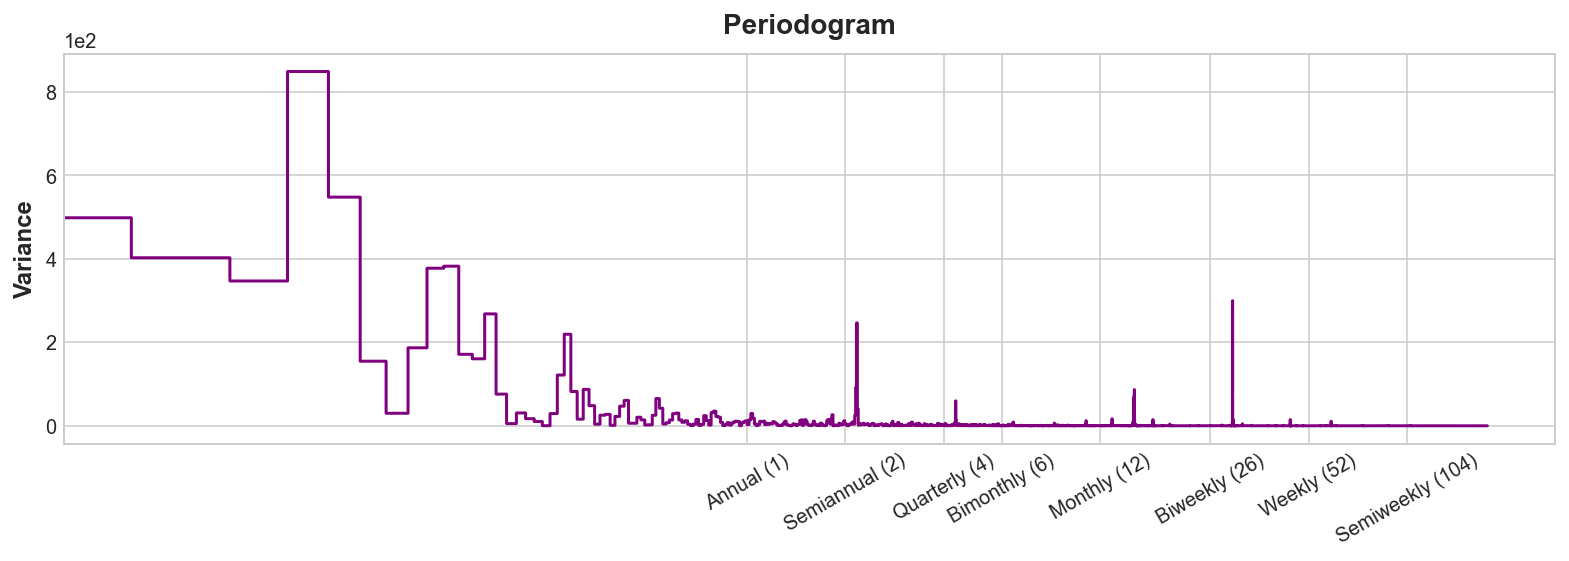

In [21]:
plot_periodogram(price.price);

### Time Series as Features

In [22]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

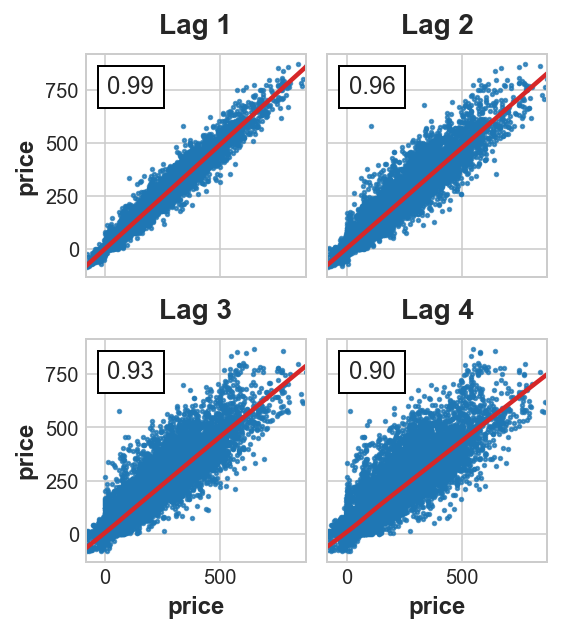

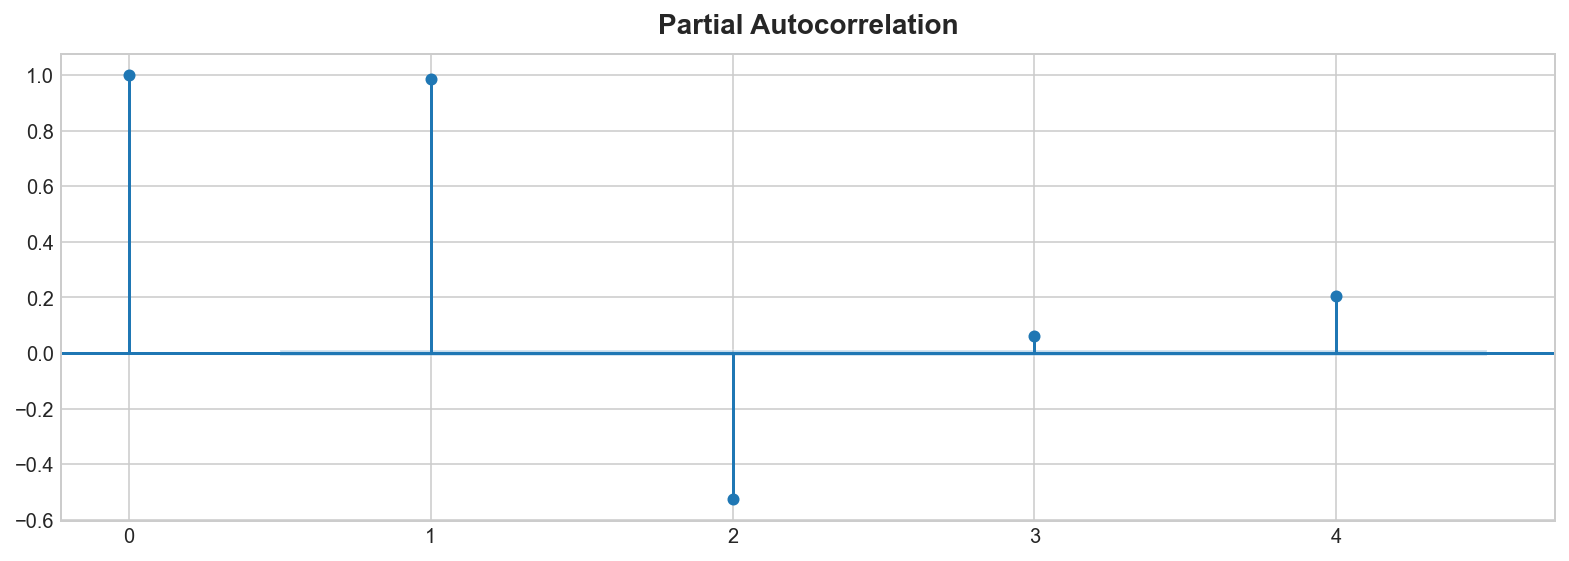

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_lags(price.price, lags=4, nrows=2)
_ = plot_pacf(price.price, lags=4)

In [24]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [25]:
X = make_lags(price.price, lags=2)
X = X.fillna(0.0)

In [26]:
from sklearn.model_selection import train_test_split
# Create target series and data splits
y = price.price.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

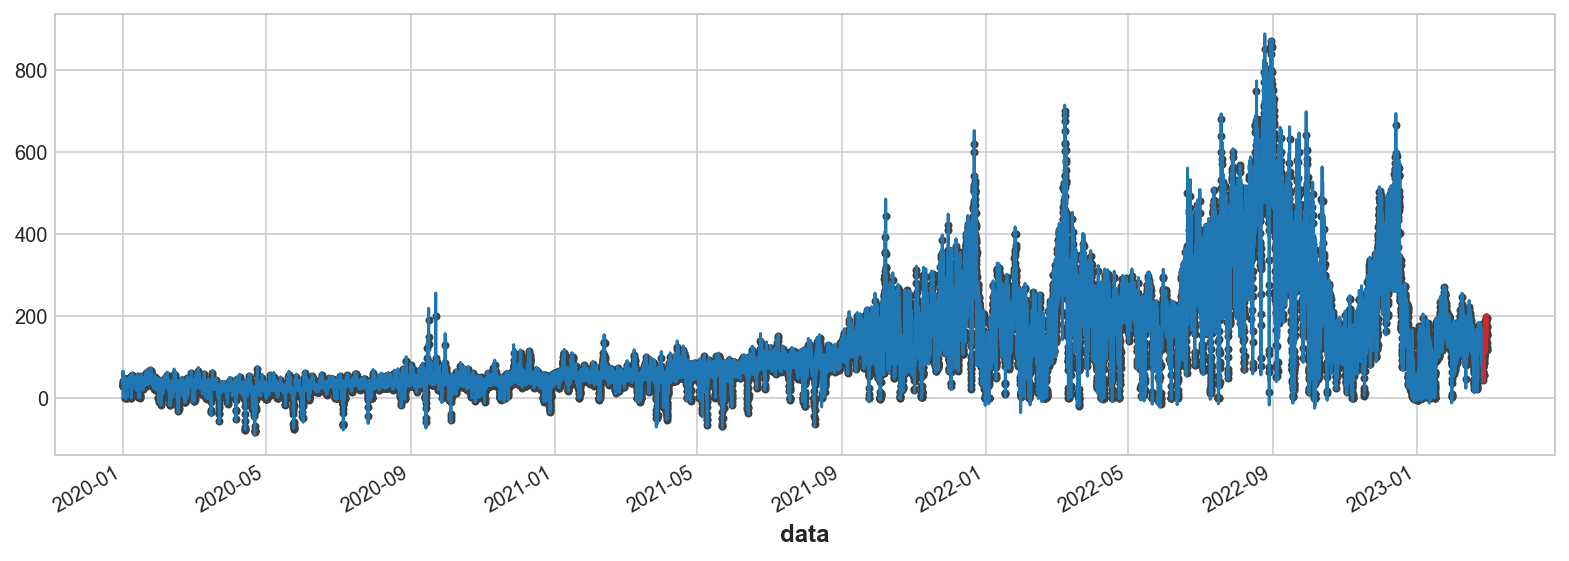

In [27]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

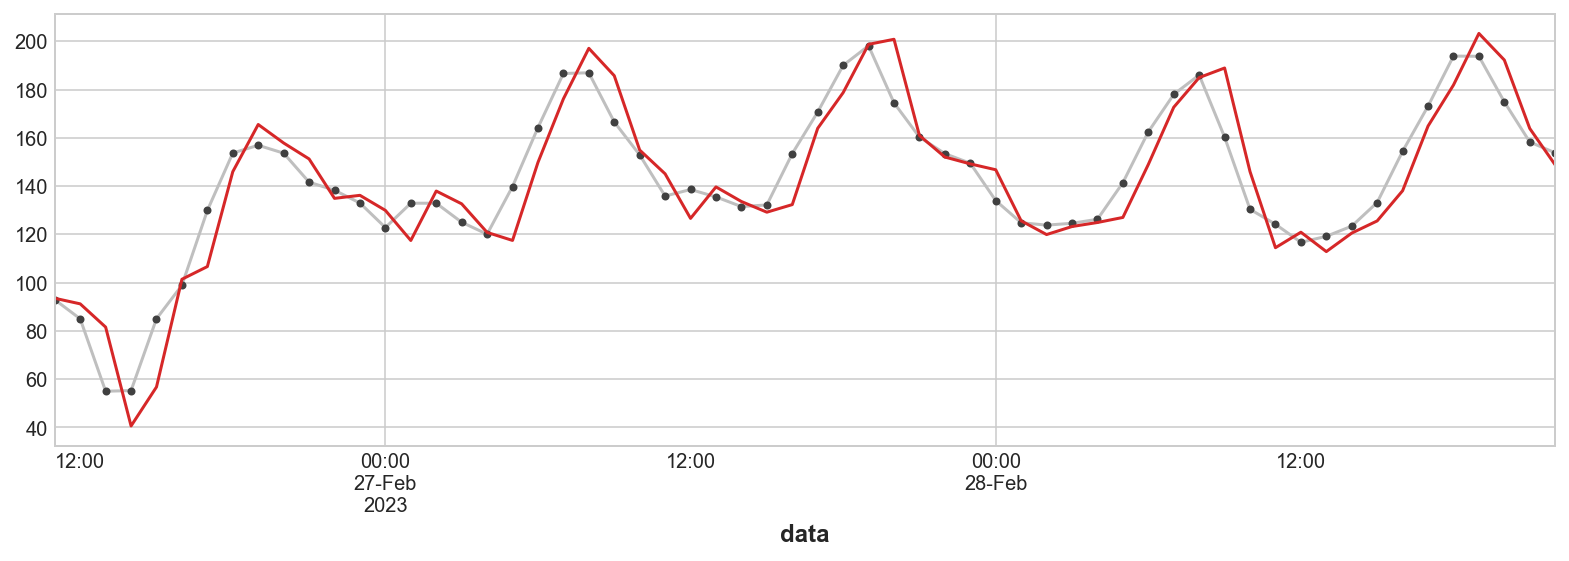

In [28]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

### Final Model

In [39]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [40]:
y = price.price.copy()
X = make_lags(y, lags=2).fillna(0.0)

In [41]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [42]:
y = make_multistep_target(y, steps=8).dropna()

In [43]:
y, X = y.align(X, join='inner', axis=0)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 34.08
Test RMSE: 80.63


In [49]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

In [50]:
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [51]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 26.11
Test RMSE: 91.83


In [53]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [54]:
kernel = DotProduct() + WhiteKernel()